# <b> <center> <font color='#7B241C'> PREPROCESSING FOR OBEJCT DETECTION </font> </center> </b>

TABLA DE CONTENIDO

<a name="1"></a>
## <b> <font color='red'> Objectives </font> </b>

El objetivo es armar paso a paso un dataset apropiado para la detección de objetos.


<a name="2"></a>
## <b> <font color='red'> 2. Modules </font>  </b>

In [2]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D, Reshape

import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')


<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font>  </b>

In [14]:
# plotting utilities
def plot_image_and_label(image, coord):
    """
    image: imagen
    coord: coordenadas de la caja delimitadora
    """
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = coord
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



In [7]:
# Ejemplo de preprocesamiento de imágenes y etiquetas
def preprocess_image(image_path):
    # Cargar la imagen y redimensionarla
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # resize mantiene los canales de color! 
    #  Normalizar los valores de píxeles al rango [0, 1]
    image = image / 255.0  
    return image


# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name

Las características son las imágenes.

Las etiquetas deben contener la clase (por ejemplo en formato one-hot) y la caja delimitadora:



Ejemplo de label para un objeto (ej: perro) y 3 clases (perro, gato, vaca)

```python
label = {
    'class': [1 0 0],
    'bbox': [x_min, y_min, x_max, y_max]
}
```



Ejemplo de label para detectar múltiples objetos (ej, hay un perro y una vaca) y 3 clases (perro, gato, vaca)



```python
labels = [
    {
        'class': [1 0 0],
        'bbox': [x_min1, y_min1, x_max1, y_max1]
    },
    {
        'class': [0 0 1],
        'bbox': [x_min2, y_min2, x_max2, y_max2]
    },
    # Otros objetos...
]
```


En nuestro problema tenemos 3 clases (banana, manzana y naranja) y detectaremos sólo uno de ellos por imagen.
Las entradas serán imágenes a color, que pueden tener distinto tamaño, y en su nombre se incluye la clase (ej: banana_1.jpg), y las cajas delimitadoras están dadas como anotaciones (a continuación se muestra un ejemplo):


<b> apple_1.xml </b>

```
<annotation>
	<folder>train</folder>
	<filename>apple_1.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>0</width>
		<height>0</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>15</ymin>
			<xmax>331</xmax>
			<ymax>349</ymax>
		</bndbox>
	</object>
</annotation>
```


Para obtener la clase y las coordendas de la caja delimitadora, debemos parsear estos datos, la función siguiente se encarga de esto:



In [17]:
# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name

Ya tenemos los datos separados en 2 carpetas:
    
- Train
- Test
    
    
Como aquí sólo nos interesa el pre-procesamiento trabajaremos sólo con los datos de train.    

Comencemos por obtener los datos.

In [4]:
# Directorio de las imágenes y anotaciones
images_dir = 'data/train'
annotations_dir = 'data/train'

In [8]:
# Listas para almacenar los nombres de archivos de imágenes y las etiquetas de las cajas delimitadoras
train_images = []
train_labels = []

# Iterar sobre los archivos de anotaciones en el directorio de anotaciones
for annotation_file in os.listdir(annotations_dir):
    if annotation_file.endswith('.xml'):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        image_name = annotation_file.replace('.xml', '.jpg')  # Obtener el nombre de la imagen correspondiente
        image_path = os.path.join(images_dir, image_name)

        # Leer las coordenadas de la caja delimitadora y la etiqueta
        xmin, ymin, xmax, ymax, label = parse_annotation(annotation_path)

        # Agregar la imagen y las etiquetas a las listas correspondientes
        train_images.append(image_path)
        train_labels.append([xmin, ymin, xmax, ymax, label])


In [10]:
# train_images contiene las rutas a las imágenes
train_images[1], train_images[10]

('data/train/banana_49.jpg', 'data/train/mixed_14.jpg')

In [12]:
# los labels contienen la caja delimitadora (en coordenadas absolutas) junto con la clase
train_labels[3],train_labels[4]

([1, 135, 1181, 601, 'banana'], [67, 8, 222, 155, 'apple'])

Imprimamos algunas imágenes junto con sus correspondientes cajas:

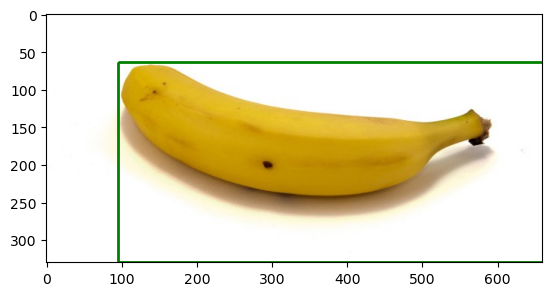

In [15]:
plot_image_and_label(Image.open(train_images[1]), train_labels[1][0:4])


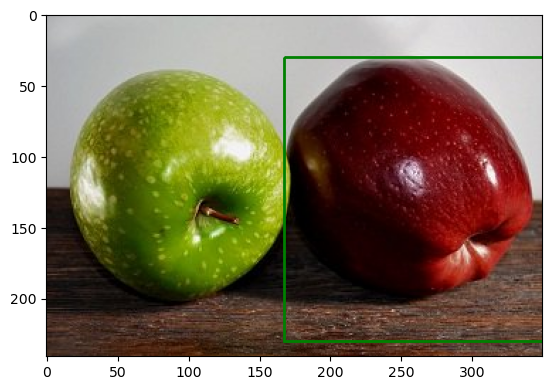

In [16]:
plot_image_and_label(Image.open(train_images[8]), train_labels[8][0:4])

Debemos pre-procesar las imágenes,

- Cambiaremos su tamaño a 224
- Normalizaremos dividiendo por 255

La función siguiente se encarga de esto:

In [18]:
# Ejemplo de preprocesamiento de imágenes y etiquetas
def preprocess_image(image_path):
    # Cargar la imagen y redimensionarla
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # resize mantiene los canales de color! 
    #  Normalizar los valores de píxeles al rango [0, 1]
    image = image / 255.0  
    return image


Imprimamos una imagen pre-procesada junto con su etiqueta:

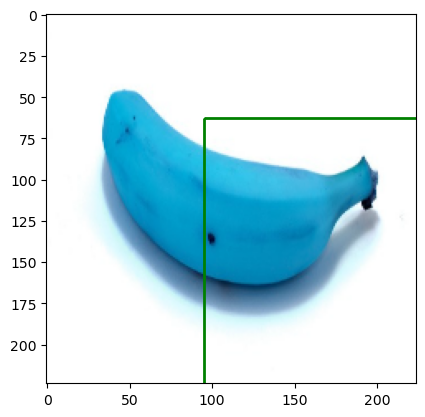

In [20]:
plot_image_and_label(preprocess_image(train_images[1]), train_labels[1][0:4])

Qué pasó? Porque la caja delimitadora dejó de ser precisa?

El problema es que las coordenadas de las cajas están dadas en forma absoluta y deben escalarse apropiadamente, la siguiente función se encarga de esto:


In [21]:
# Función para escalar las coordenadas de la bounding box
def scaling_coordinates(coord, width, height, resized_width, resized_height):
    x, y, w, h = coord
    scale_x = resized_width / width # tamaño del resized dividio el actual
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]

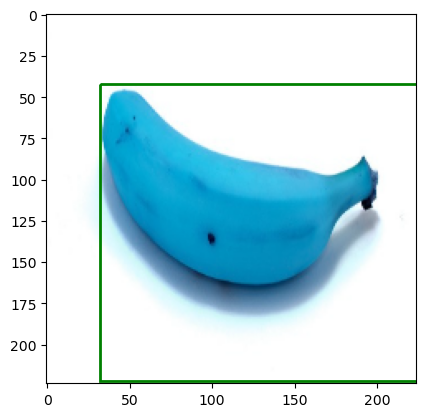

In [25]:

image = cv2.imread(train_images[1])
height, width, channels = image.shape

scaled_coord = scaling_coordinates(train_labels[1][0:4], width, height, 224, 224)


plot_image_and_label(preprocess_image(train_images[1]), scaled_coord)

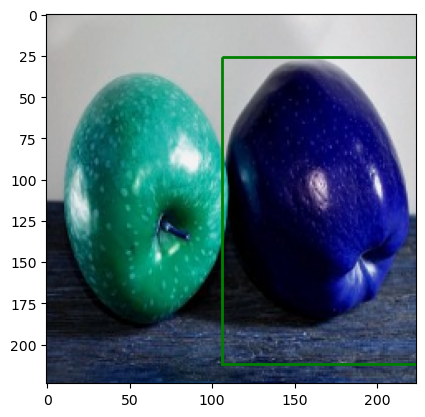

In [26]:
image = cv2.imread(train_images[8])
height, width, channels = image.shape

scaled_coord = scaling_coordinates(train_labels[8][0:4], width, height, 224, 224)


plot_image_and_label(preprocess_image(train_images[8]), scaled_coord)

In [ ]:
El pre-procesamiento de las imágenes lo haremos cuando armemos el dataset.

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font>  </b>

In [34]:
# plotting utilities

def plot_image_and_labels(image_path, label):
    # Cargar la imagen
    image = Image.open(image_path)
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = label[0:4] # 
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



# bad; falta escalar la caja acorde
def plot_image_and_label(image_path, label): 
    image = preprocess_image(image_path)
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = label[0:4] # 
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



    
    

    

# Función para escalar las coordenadas de la bounding box
def scaling_coordinates(coord, width, height, resized_width, resized_height):
    x, y, w, h = coord
    scale_x = resized_width / width
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]
    
    
    
# image size (width, height and channels)
def get_image_size(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    # Obtener el tamaño de la imagen
    height, width, channels = image.shape
    return width, height, channels

In [4]:


"""
PNG
def load_and_preprocess_image(image_path, bbox):
    # Cargar la imagen
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Decodificar la imagen en formato PNG
    image = tf.image.resize(image, [224, 224])  # Redimensionar la imagen a 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar los valores de píxeles al rango [0, 1]
    return image, bbox
"""




# Ejemplo de preprocesamiento de imágenes y etiquetas
def preprocess_image(image_path):
    # Cargar la imagen y redimensionarla
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # resize mantiene los canales de color! 
    #  Normalizar los valores de píxeles al rango [0, 1]
    image = image / 255.0  
    return image


# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name

<a name="4"></a>
## <b> <font color='red'> 4. Loading, exploring and pre-processing data </font>  </b>

In [5]:
# Directorio de las imágenes y anotaciones
images_dir = 'data/train'
annotations_dir = 'data/train'

In [26]:
# Listas para almacenar los nombres de archivos de imágenes y las etiquetas de las cajas delimitadoras
train_images = []
train_labels = []

# Iterar sobre los archivos de anotaciones en el directorio de anotaciones
for annotation_file in os.listdir(annotations_dir):
    if annotation_file.endswith('.xml'):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        image_name = annotation_file.replace('.xml', '.jpg')  # Obtener el nombre de la imagen correspondiente
        image_path = os.path.join(images_dir, image_name)
        
        
        # Leer las coordenadas de la caja delimitadora y la etiqueta
        xmin, ymin, xmax, ymax, label = parse_annotation(annotation_path)
        # scaling
        width, height, _ = get_image_size(image_path)
        xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled = scaling_coordinates([xmin, ymin, xmax, ymax], 
                                                                                 width, height, 224, 224)
        
        
        
        # Agregar la imagen y las etiquetas a las listas correspondientes
        train_images.append(image_path)
        train_labels.append([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled, label])
        #train_labels.append([xmin, ymin, xmax, ymax, label])
        
        
        

# Verificar los datos obtenidos
#print("Nombres de archivos de imágenes:", train_images)
print("Etiquetas de las cajas delimitadoras:", train_labels[3],train_labels[4])




libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Etiquetas de las cajas delimitadoras: [0, 48, 220, 213, 'banana'] [63, 10, 208, 206, 'apple']


In [12]:
train_images[2], train_labels[2]

('data/train/apple_42.jpg', [17, 24, 199, 212, 'apple'])

In [20]:
train_images[1]


get_image_size(train_images[1])


(330, 660, 3)

In [ ]:
# [1, 135, 1181, 601, 'banana'] [67, 8, 222, 155, 'apple']

Vemos que train_images son los paths a las imágenes y que train_labels está compuesto por las coordenadas de la caja delimitadora y la clase.

### Plot image

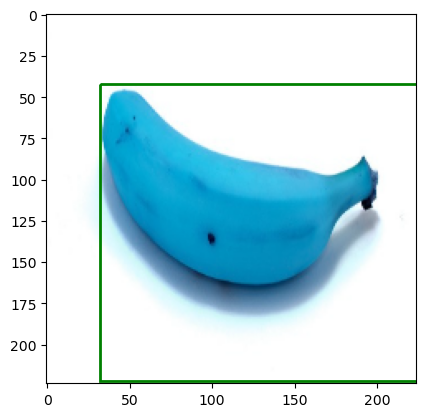

In [35]:
# veamos qué pasa si hago un pre-procesamiento de la imagen, pero
# no re-escalo apropiadamente la bounding box
plot_image_and_label(train_images[1], train_labels[1])

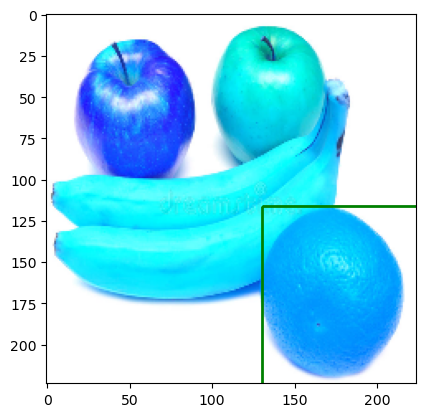

In [36]:
plot_image_and_label(train_images[7], train_labels[7])

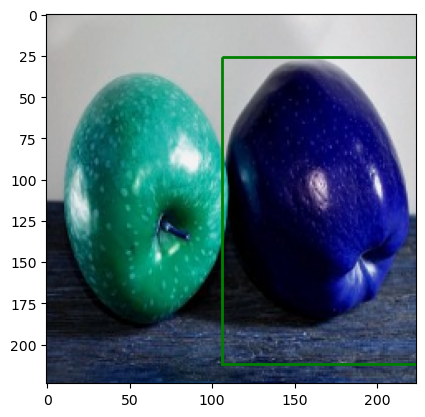

In [37]:
plot_image_and_label(train_images[8], train_labels[8])

De momento las labels tenemos como [17, 24, 199, 212, 'apple'], queremos que sean [{'bbox',...., 'class'}]

In [27]:
# labels
labels = []
for l in train_labels:
    labels.append({'bbox':l[0:4], 'class': l[4]})
    
# vemos un par de datos
labels[2:4]

[{'bbox': [39, 55, 445, 474], 'class': 'apple'},
 {'bbox': [1, 135, 1181, 601], 'class': 'banana'}]

Nos falta:

- Escalar las coordenadas
- Codificar las etiquetas
    - Como no hay una relación de orden y además son pocas clases usaremos one-hot encoding.

Comencemos por codificar la clase como one-hot:

In [28]:
# debemos convertir las clases a one-hot
# Obtener todas las clases únicas
unique_classes = set(label['class'] for label in labels) # ['banana', 'apple', 'orange']

# Crear un diccionario de codificación one-hot
one_hot_encoding = {class_name: [0] * len(unique_classes) for class_name in unique_classes}
for i, class_name in enumerate(unique_classes):
    one_hot_encoding[class_name][i] = 1

# Codificar cada clase
one_hot_labels = []
for label in labels:
    class_name = label['class']
    one_hot_labels.append({
        'class': one_hot_encoding[class_name],
        'bbox': label['bbox']
    })

# Imprimir las etiquetas one-hot resultantes
for label in one_hot_labels:
    print("Clase codificada one-hot:", label['class'])
    print("Caja delimitadora:", label['bbox'])
    break

Clase codificada one-hot: [0, 0, 1]
Caja delimitadora: [304, 105, 773, 439]


In [30]:
# veamos un par de etiquetas
one_hot_labels[2:4]

[{'class': [0, 0, 1], 'bbox': [39, 55, 445, 474]},
 {'class': [0, 1, 0], 'bbox': [1, 135, 1181, 601]}]

Ya tenemos las etiquetas como one-hot, sólo resta escalar las coordenadas.

In [40]:

# darle otro nombre


#scaling_coordinates(coord, width, height, resized_width, resized_height):
for data in zip(train_images, one_hot_labels):
    image = cv2.imread(data[0])
    height, width, channels = image.shape
    data[1]['bbox'] = scaling_coordinates(data[1]['bbox'], width, height, 224, 224)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [42]:
one_hot_labels[2:4] # comparando vemos que las coordendas fueron escaladas

[{'class': [0, 0, 1], 'bbox': [7, 10, 89, 94]},
 {'class': [0, 1, 0], 'bbox': [0, 17, 41, 75]}]

### Creamos el dataset

In [43]:
# pre-procesamiento de las imágenes
images = [preprocess_image(path) for path in train_images]

# Convertir las coordenadas de las cajas delimitadoras a tensores
bounding_boxes = tf.constant([obj['bbox'] for obj in one_hot_labels], dtype=tf.float32)

# Convertir las clases a tensores
classes = tf.constant([obj['class'] for obj in one_hot_labels], dtype=tf.float32) # labels

# Crear un diccionario de tensores
dataset_labels = {'bbox': bounding_boxes, 'class': classes}

# Crear el conjunto de datos
dataset = tf.data.Dataset.from_tensor_slices((images, dataset_labels))

# Define el tamaño del batch y mezcla los datos
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).shuffle(buffer_size=len(images))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
2024-03-06 20:59:40.056153: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.


In [44]:
for x,y in dataset:
    print(x, y)
    break

2024-03-06 20:59:56.551059: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.


tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.      

<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train model </font>  </b>

In [45]:
num_classes = 3

In [46]:
# Definir la arquitectura de la CNN
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool2)
flatten = tf.keras.layers.Flatten()(conv3)
dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
output_class = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(dense1)
output_bbox = tf.keras.layers.Dense(4, activation='linear', name='bbox')(dense1)  # 4 coordenadas para la caja delimitadora

# Construir el modelo
model = tf.keras.Model(inputs=input_layer, outputs=[output_class, output_bbox]) #, output_bbox

# Compilar el modelo con diferentes métricas y funciones de pérdida para cada salida
model.compile(optimizer='adam',
              loss={'class': 'categorical_crossentropy', 'bbox': 'mse'},
              metrics={'class': 'accuracy', 'bbox': 'mae'})

# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

In [47]:
# Entrenar el modelo
model.fit(
        dataset,
        epochs=1)

8/8 [==============================] - 9s 932ms/step - loss: 3003.7009 - class_loss: 21.8756 - bbox_loss: 2981.8250 - class_accuracy: 0.3000 - bbox_mae: 37.1685


In [ ]:
# Labels para un solo objeto (por ejemplo, un perro)
label = {
    'class': 'perro',
    'bbox': [x_min, y_min, x_max, y_max]
}



# Labels para múltiples objetos
labels = [
    {
        'class': 'perro',
        'bbox': [x_min1, y_min1, x_max1, y_max1]
    },
    {
        'class': 'gato',
        'bbox': [x_min2, y_min2, x_max2, y_max2]
    },
    # Otros objetos...
]

Cuando redimensionas una imagen y también necesitas ajustar las coordenadas de las cajas delimitadoras (bounding boxes), es importante comprender cómo afecta esto al proceso de detección de objetos. La ubicación de la caja delimitadora en relación con la imagen es crucial para la precisión de la detección. Aquí hay algunos puntos importantes a considerar:

Coordenadas Relativas vs. Absolutas:

Las coordenadas de las cajas delimitadoras pueden ser relativas o absolutas.
Las coordenadas relativas son proporcionales al tamaño de la imagen. Por ejemplo, (0.5, 0.5) significaría el centro de la imagen.
Las coordenadas absolutas son específicas del tamaño de la imagen original. Por ejemplo, (100, 100) podría ser la esquina superior izquierda de una imagen de 200x200 píxeles.
Impacto del Resize:

Si redimensionas la imagen, las coordenadas de las cajas delimitadoras también deben ajustarse en consecuencia para mantener la coherencia en la detección de objetos.
Si las coordenadas de las cajas delimitadoras están en formato relativo, no necesitas ajustarlas siempre que el método de redimensionamiento conserve las proporciones de la imagen.
Si las coordenadas son absolutas, deberás escalarlas de acuerdo con el factor de redimensionamiento aplicado a la imagen.
Métodos de Redimensionamiento:

Algunos métodos de redimensionamiento pueden conservar mejor la relación de aspecto de la imagen que otros. Es preferible utilizar métodos que preserven la relación de aspecto para evitar distorsiones.
Precaución con las Transformaciones No Lineales:

Algunas transformaciones no lineales, como la distorsión geométrica, pueden alterar significativamente las formas y proporciones de los objetos en la imagen, lo que hace que las cajas delimitadoras redimensionadas sean menos precisas.
En resumen, cuando redimensionas una imagen para el procesamiento, es fundamental ajustar adecuadamente las coordenadas de las cajas delimitadoras para mantener la precisión de la detección de objetos. Esto se logra ajustando las coordenadas de las cajas delimitadoras en proporción al cambio en las dimensiones de la imagen.

In [1]:
import numpy as np

# Tamaño de las imágenes redimensionadas
resized_width = 224
resized_height = 224

# Datos de las bounding boxes y clases
bounding_boxes_data = [
    [39, 55, 445, 474, 'apple'],
    [39, 55, 445, 400, 'banana']
    # Agrega más datos según sea necesario
]

# Función para escalar las coordenadas de la bounding box
def escalar_coordenadas(coord, width, height):
    x, y, w, h = coord
    scale_x = resized_width / width
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]

# Escalar coordenadas y convertir clases a one-hot
datos_preprocesados = []
clases = set()

for box_data in bounding_boxes_data:
    coord_escala = escalar_coordenadas(box_data[:4], box_data[2], box_data[3])
    clase = box_data[4]
    clases.add(clase)

    # Convertir la clase a one-hot
    one_hot_clase = [0] * len(clases)
    one_hot_clase[list(clases).index(clase)] = 1

    datos_preprocesados.append(coord_escala + one_hot_clase)

datos_preprocesados = np.array(datos_preprocesados)

print("Datos preprocesados:")
print(datos_preprocesados)


Datos preprocesados:
[list([19, 25, 224, 224, 1]) list([19, 30, 224, 224, 0, 1])]


/tmp/ipykernel_361576/2143440426.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datos_preprocesados = np.array(datos_preprocesados)


In [8]:
import cv2

# Cargar la imagen
image = cv2.imread(train_images[1])

# Obtener el tamaño de la imagen
height, width, channels = image.shape

print("Ancho de la imagen:", width)
print("Alto de la imagen:", height)
print("Canales de color:", channels)

Ancho de la imagen: 660
Alto de la imagen: 330
Canales de color: 3
